In [1]:
### GLOBAL CONFIG VARIABLES
WITH_CHANNEL = False
WITH_FLATTEN = False
SCALE = 100
DIM = 50

In [2]:
import plotly.graph_objects as go
import plotly.io as pio
import random
import re
from datetime import datetime
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import gzip
import pandas as pd
import random
import numpy as np
import warnings
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from copy import deepcopy
from sklearn.model_selection import train_test_split
from datetime import datetime

# Import Libraries
import os
import json
import torch
import torchvision
from PIL import Image
import glob
import matplotlib.pyplot as plt
from random import shuffle

# from google.colab import drive
import os

# drive.mount('/content/drive')



warnings.simplefilter("ignore")


# Util Functions

In [3]:
def set_seed(seed):
    if seed != None:
        np.random.seed(seed)
        random.seed
        torch.manual_seed(seed)

def noise(dims, loc=0, scale=SCALE/50):
    ''' generate normal N(0,1) noise '''
    return np.random.normal(loc=loc, scale=scale, size=dims)

def extract_middle(x):
    '''
    given tensor of x (normally real_x) with dim (batch_size, 1, 3*DIM, DIM),
    extract the middle data
    '''
    return x[:,:,DIM:2*DIM,:]

def set_middle(x, middle):
    '''
    given 2 tensors, replace the middle data for x with the data in `middle`
    x (normally real_x) with dim (batch_size, 1, 3*DIM, DIM)
    middle with dim (batch_size, 1, DIM, DIM)
    '''
    x = x.cpu().data.numpy()
    # x = np.array(x)                                                             # transform both to array
    middle = np.array(middle)                                                   # transform both to array
    x[:,:,DIM:2*DIM,:] = middle                                                 # replace middle value of `x` with `middle`
    return torch.tensor(x)

def make_fake_middle(x):
    '''
    given tensor of x (normally real_x) with dim (batch_size, 1, 3*DIM, DIM),
    replace the middle data with noise
    '''
    fake_x = deepcopy(x)                                                        # create a deepcopy of the given x

    middle_dim = extract_middle(x).shape                                        # determine shape of the middle data
    fake_middle = noise(middle_dim)                                             # generate noise
    fake_x = set_middle(fake_x, fake_middle)                                    # replace the middle with generated noise
    return fake_x

def shape(x):
    '''print shape of x'''
    print(x.shape)


def rescale(x, lower, upper, scale=1):
    '''Rescales an array to it fits within the range [0,1]'''
    return scale * (x - lower) / (upper - lower)

def split(x):
    x0 = x[:,:, 0*DIM:1*DIM, :]
    x1 = x[:,:, 1*DIM:2*DIM, :]
    x2 = x[:,:, 2*DIM:3*DIM, :]
    return x0, x1, x2

def save_model(model, PATH):
    torch.save(model.state_dict(), PATH)

def load_model(model_class, params, PATH):
    model = model_class(params)
    model.load_state_dict(torch.load(PATH))
    return model

# Data (Data and Dataloader)

## **Be sure to change the folder path and file name for the data you want to use to train the model**

In [6]:
random.seed(0)

folder_path = "./data_processing/" # Set this with the path to the directory that contains your .npy file
file_name = "data_more.npy" # Set this with the name of your data file

In [8]:
datas = np.load(os.path.join(folder_path, file_name))[:,:,:,2]
datas.shape

print("\n-- reshaping and rescaling --")

print("original shape:", datas.shape)
if WITH_FLATTEN:
    raise Exception("Not Supported")
    # datas = np.array([np.hstack(data) for data in datas])
    # print(datas.shape)
    # datas = datas.reshape(datas.shape[0], 1, 50, 50)
else:
    datas = datas.reshape(datas.shape[0], 3, DIM, DIM)
    # print(datas.shape)
    if not WITH_CHANNEL:
        datas = datas.reshape(datas.shape[0], 3*DIM, DIM)
        # print(datas.shape)
        datas = datas.reshape(datas.shape[0], 1, 3*DIM, DIM)
        # print(datas.shape)
print("final shape:", datas.shape)

# Rescale all data so each "group" of data is from [0,1]. Drop all data where min==max, as this implies there is no percipitation data
new_datas = []
errors = 0
for i in range(datas.shape[0]):
    data = datas[i]
    if min(data.flatten()) == max(data.flatten()):
        errors+=1
        continue
    new_data = rescale(data, min(data.flatten()), max(data.flatten()), scale=SCALE)
    new_datas.append(new_data)

datas = np.array(new_datas)
print("rescaled shape:", datas.shape)


-- reshaping and rescaling --
original shape: (58056, 3, 2500)
final shape: (58056, 1, 150, 50)
rescaled shape: (51021, 1, 150, 50)


In [9]:
tr = 0.75
va = 0.20
te = 0.05

# datas = torch.from_numpy(datas)

# datas = datas.cuda()

tr_data, _ = train_test_split(datas, test_size = va+te)
va_data, te_data = train_test_split(_, test_size = te/(va+te))

# tr_data = torch.from_numpy(tr_data)
# va_data = torch.from_numpy(va_data)
# te_data = torch.from_numpy(te_data)

train_dataloader = DataLoader(tr_data, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(va_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(te_data, batch_size=64, shuffle=True)

tr_data.shape, va_data.shape, te_data.shape

((38265, 1, 150, 50), (10204, 1, 150, 50), (2552, 1, 150, 50))

# Define Intermediate Autoencoder (IAE)

In [10]:
# https://github.com/RutvikB/Image-Reconstruction-using-Convolutional-Autoencoders-and-PyTorch/blob/main/config.json

import tqdm
class IAE(torch.nn.Module):
    def __init__(self, params):
        super().__init__()

        ### Set parameters and seed
        self.params = params
        self.lr = params["lr"]
        self.wd = params["weight_decay"]
        self.n_epochs = params["n_epochs"]
        set_seed(params["seed"])

        ### Set encoder and decoder channel input/output values
        dims = [1, 6, 16, 32, 64]
        encoder_dims = [(a,b) for a,b in zip(dims[:-1], dims[1:])]
        dims.reverse()
        decoder_dims = [(a,b) for a,b in zip(dims[:-1], dims[1:])]

        ### Create encoder layer
        self.encoder = []
        for dima,dimb in encoder_dims:
            self.encoder.append(nn.Conv2d(dima, dimb, kernel_size=3, stride=2))
            self.encoder.append(nn.ReLU(True))
        self.encoder = nn.Sequential(*self.encoder)

        ### Create decoder
        self.decoder = []
        for dima,dimb in decoder_dims:
            self.decoder.append(nn.ConvTranspose2d(dima, dimb, kernel_size=3, stride=2))
            self.decoder.append(nn.ReLU(True))
        # add decoder padding (to match dimensions)
        self.decoder[2] = nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1,0))
        self.decoder[4] = nn.ConvTranspose2d(16, 6, kernel_size=(3, 3), stride=(2, 2), output_padding=1)
        self.decoder[6] = nn.ConvTranspose2d(6, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=1)

        self.decoder = nn.Sequential(*self.decoder)

        ### Create model optimizer
        self.optim = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)

    def forward(self, x):
        '''
        Forward pass on the model
        '''
        x = x.cuda()
        z = self.encoder(x)
        recon_x1 = self.decoder(z)
        return recon_x1

    def train_all(self, dataloader, do_print=True):
        '''
        Train model on data
        '''
        self.losses = []
        self.batch_loss = []
        for epoch in tqdm.tqdm(range(self.n_epochs)):
            epoch_loss = 0
            for i, img in enumerate(train_dataloader):
                
                # train for one epoch

                ### Set Training Image
                img = img.float()
                img = img.to(device)
                img = torch.autograd.Variable(img)
                noise_img = make_fake_middle(img)                               # replace middle x1 with noise

                # noise_img = noise_img.cuda()

                ### Run the Model and Get Loss
                recon_img = IAE_model(noise_img)

                # recon_img = recon_img.cuda()
                loss = self.loss(recon_img, img)
                loss = loss.cpu()

                ### Update weights
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

                ### Record Losses
                loss = loss.detach().numpy()
                self.batch_loss.append(loss)
                epoch_loss += loss

            ### Record Epoch Losses
            epoch_loss = epoch_loss/len(train_dataloader)
            self.losses.append(epoch_loss)

            if do_print:
                print("Epoch: {} | Loss: {:.4f}".format(epoch+1, epoch_loss))
        self.losses = np.array(self.losses)
        self.batch_loss = np.array(self.batch_loss)

    def loss(self, recon_x, x):
        '''Calculate Loss'''
        return torch.nn.MSELoss().to(device)(recon_x.cuda(), x.cuda())

# Train IAE

In [11]:
params = {
    "lr": 0.001,
    "weight_decay": 0,
    "n_epochs": 20,
    "seed": 3
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IAE_model = IAE(params).to(device)
IAE_model.train_all(train_dataloader, do_print=False)

100%|██████████| 20/20 [01:06<00:00,  3.33s/it]


# Generate Visualizations

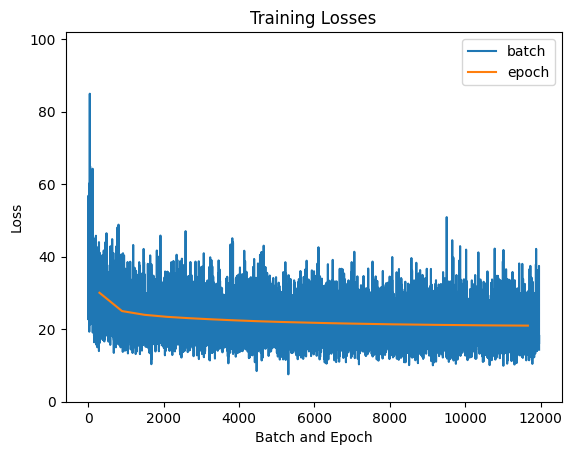

In [12]:
# THIS CELL WILL NOT WORK IF YOU LOADED A MODEL

iter_per_batch = len(IAE_model.batch_loss) / params["n_epochs"]

plt.plot(np.arange(len(IAE_model.batch_loss)), IAE_model.batch_loss, label="batch")
plt.plot(np.arange(iter_per_batch/2,len(IAE_model.batch_loss),iter_per_batch), IAE_model.losses, label="epoch")
plt.title("Training Losses")
plt.ylabel("Loss")
plt.xlabel("Batch and Epoch")
plt.ylim(0, max(IAE_model.batch_loss)*1.2)
plt.legend();

In [13]:
min(IAE_model.losses)

20.989475884963838

## Generate Images

### Change SEED to sample different test images

In [16]:
SEED = 100

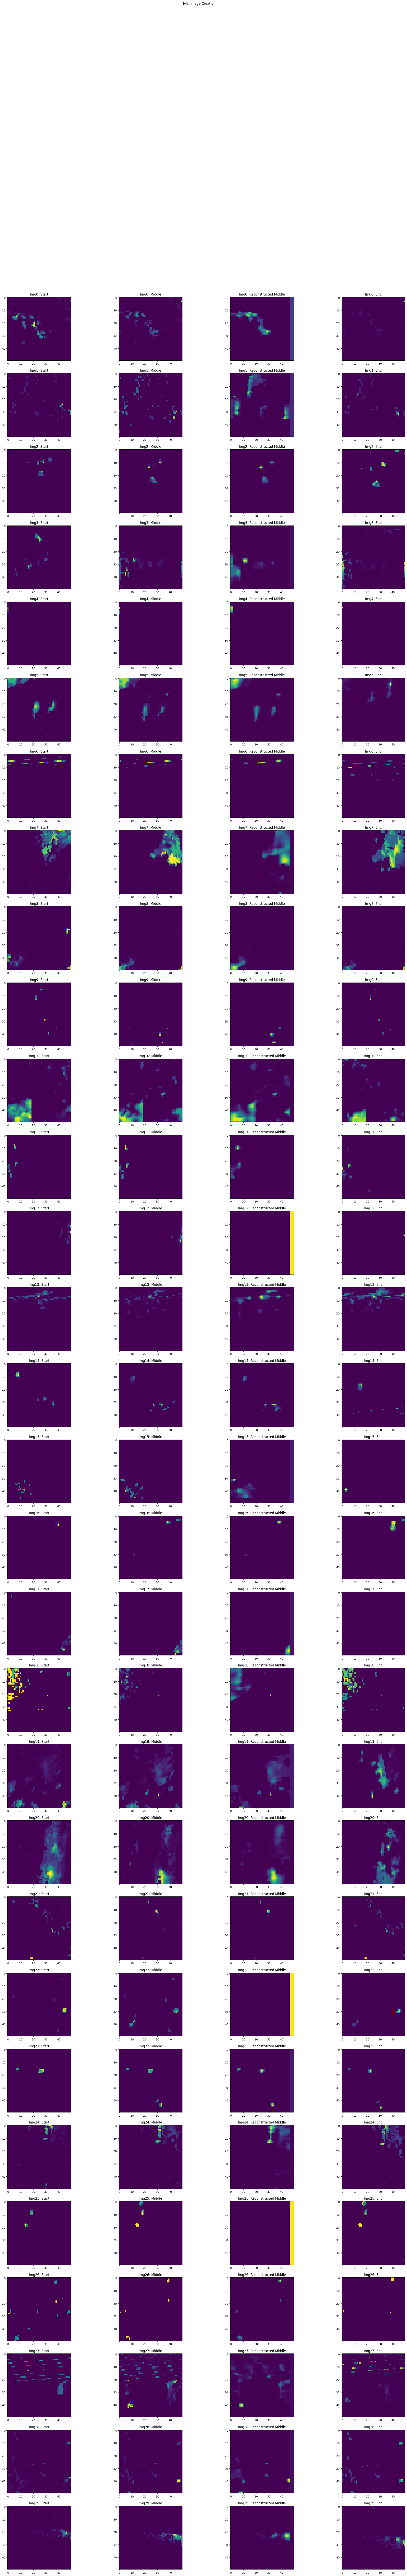

In [17]:
cnt = 30

fig, ax = plt.subplots(nrows=cnt, ncols=4, figsize=(4*7, cnt*5))

set_seed(SEED)

for img in test_dataloader:
    img = img.float()
    img = img.to(device)
    img = torch.autograd.Variable(img)

    img = img.cpu()


    recon = IAE_model(img)
    recon = recon.cpu()

    for i in range(cnt):

        ax[i,0].imshow(img[i][0][0*DIM:1*DIM].detach().numpy())
        ax[i,0].set_title(f'Img{i}: Start')

        ax[i,1].imshow(img[i][0][1*DIM:2*DIM].detach().numpy())
        ax[i,1].set_title(f'Img{i}: Middle')

        ax[i,2].imshow(recon[i][0][1*DIM:2*DIM].detach().numpy())
        ax[i,2].set_title(f'Img{i}: Reconstructed Middle')

        ax[i,3].imshow(img[i][0][2*DIM:3*DIM].detach().numpy())
        ax[i,3].set_title(f'Img{i}: End')


    plt.suptitle("IAE, Image Creation")
    break

plt.show();

# Save/Load Model

In [ ]:
model_path = os.path.join('./', "IAE_model.pt")

In [37]:
# Save Model
save_model(IAE_model, model_path)

In [ ]:
# Load Model
IAE_model = load_model(IAE, params, model_path).to(device)